# Dataset Construction
## Song Lyric Generation with GPT-2
**Data Mining Final Project**<br>
Khyatee Desai<br>Dec. 19, 2022

- compare verb/nouns 
- look at frequency of repeated words
- number of stop words
- free form prompts for empirical evaluation
- look for common beatles themes (heartbreak, girl, dancing,)
- syllable counts

In [94]:
# !pip install transformers
# !pip install torch
# !pip install stop_words

In [95]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt 
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline
import statistics
from nltk.translate.bleu_score import sentence_bleu
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

In [4]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model

def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

def generate_text(sequence, max_length, temp):
    model_path = "results_report"
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95, temperature=temp
    )
    return(tokenizer.decode(final_outputs[0], skip_special_tokens=True))

In [5]:
naive_model = pipeline('text-generation', model='gpt2-medium')
naive_model("Hello, I'm a language model,", max_length=30, num_return_sequences=1)[0]['generated_text']


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Hello, I'm a language model, not a runtime model!\n\nWe've come to learn to understand how a language works by understanding why languages"

In [6]:
test = pd.read_parquet('testing_lyrics.parquet').reset_index(drop=True)
test.head()

,lyrics
0,"Don't let me down, don't let me down Don't let..."
1,I get high when I see you go by My oh my When ...
2,[All too much!] It's all too much It's all to...
3,"I love you, 'cause you tell me things I want t..."
4,Is there anybody going to listen to my story A...


In [17]:
# test['input'] = test['lyrics'].apply(lambda x: ' '.join(x.split()[:50])) # 50 tokens
# test['tuned_prediction'] = test['input'].apply(lambda input_text: generate_text(input_text ,200, temp=.7)) # 200 tokens
# test['naive_prediction'] = test['input'].apply(lambda input_text: naive_model(input_text, max_length=200, num_return_sequences=1)[0]['generated_text'])
# test.to_parquet('predictions.parquet')

In [18]:
preds = pd.read_parquet('predictions.parquet')
preds['lyrics_end'] = preds['lyrics'].apply(lambda x: ' '.join(x.split()[50:150])) # 100 tokens
preds['naive_prediction_end'] = preds['naive_prediction'].apply(lambda x: ' '.join(x.split()[50:150])) # 100 tokens
preds['tuned_prediction_end'] = preds['tuned_prediction'].apply(lambda x: ' '.join(x.split()[50:150])) # 100 tokens
preds.head()

,lyrics,input,naive_prediction,tuned_prediction,lyrics_end,naive_prediction_end,tuned_prediction_end
0,"Don't let me down, don't let me down Don't let...","Don't let me down, don't let me down Don't let...","Don't let me down, don't let me down Don't let...","Don't let me down, don't let me down Don't let...","let me down Don't let me down, don't let me do...",let me down I love you (more and louder) I lov...,"let me down Don't let me down, don't let me do..."
1,I get high when I see you go by My oh my When ...,I get high when I see you go by My oh my When ...,I get high when I see you go by My oh my When ...,I get high when I see you go by My oh my When ...,is all But it's so hard loving you Is it right...,all I can do Why is there not more love in you...,is all But it's so hard loving you Is it right...
2,[All too much!] It's all too much It's all to...,[All too much!] It's all too much It's all too...,[All too much!] It's all too much It's all too...,[All too much!] It's all too much It's all too...,"Everywhere, it's what you make For us to take,...",seems to be gone forever Now I'm just another ...,"Everywhere, it's what you make For us to take,..."
3,"I love you, 'cause you tell me things I want t...","I love you, 'cause you tell me things I want t...","I love you, 'cause you tell me things I want t...","I love you, 'cause you tell me things I want t...","the reason why If I cry, it's not because I'm ...",And never ever forget that I'm my own mother O...,"I Would love to love you And to hold you, to l..."
4,Is there anybody going to listen to my story A...,Is there anybody going to listen to my story A...,Is there anybody going to listen to my story A...,Is there anybody going to listen to my story A...,so hard to leave her She will turn to me and s...,"to forget. Ah, girl when I think of all the ti...",so hard to leave her She will turn to me and s...


## BLEU Score

In [20]:
i = 10
print(preds['input'][i],'\n')
print(preds['lyrics_end'][i],'\n')
print(preds['naive_prediction_end'][i],'\n')
print(preds['tuned_prediction_end'][i])

I'm looking through you, where did you go? I thought I knew you, what did I know? You don't look different, but you have changed I'm looking through you, you're not the same Your lips are moving, I cannot hear Your voice is soothing, but the words aren't clear You 

don't sound different, I've learned the game I'm looking through you, you're not the same Why, tell me why, did you not treat me right? Love has a nasty habit of disappearing overnight You're thinking of me, the same old way You were above me, but not today The only difference is you're down there I'm looking through you, and you're nowhere Why, tell me why, did you not treat me right? Love has a nasty habit of disappearing overnight I'm looking through you, where did you go I thought I knew you, what did I know You don't look 

are not smiling and I don't think I can see Your lips are moving, I cannot hear My ears hear whispers, I cannot find you You, your eyes are bright and shining, the sound echoes, You are not the same

In [23]:
def tokenize(string):
    return(string.lower().replace(',','').replace('(','').replace(')','').replace("?",'').split(' '))

In [34]:
tuned_scores=[]
for i in range(len(preds)):
    reference = [tokenize(preds['lyrics_end'][i])]
    candidate = tokenize(preds['tuned_prediction_end'][i])
    tuned_scores.append(sentence_bleu(reference, candidate))

bleu_scores = pd.DataFrame(tuned_scores).rename(columns={0:'tuned'})

naive_scores=[]
for i in range(len(preds)):
    reference = [tokenize(preds['lyrics_end'][i])]
    candidate = tokenize(preds['naive_prediction_end'][i])
    naive_scores.append(sentence_bleu(reference, candidate))

bleu_scores['naive'] = naive_scores
bleu_scores

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

,tuned,naive
0,3.101452e-01,8.428038e-79
1,5.232767e-01,6.934361e-02
2,2.414355e-01,3.274880e-155
3,1.662015e-01,1.531700e-78
4,2.016222e-01,4.934581e-02
5,5.179828e-01,3.799095e-155
6,8.766711e-01,3.655267e-02
7,9.156388e-02,5.323806e-02
8,4.236070e-01,1.805356e-155
9,1.797662e-01,1.169824e-231


In [39]:
print('Average BLEU for tuned model predictions:',bleu_scores.tuned.mean())
print('Average BLEU for naive model predictions:',bleu_scores.naive.mean())

Average BLEU for tuned model predictions: 0.42380594791026766
Average BLEU for naive model predictions: 0.03918497577015541


## Parts of Speech

In [40]:
preds[['input', 'lyrics_end', 'naive_prediction_end','tuned_prediction_end']].head()

,input,lyrics_end,naive_prediction_end,tuned_prediction_end
0,"Don't let me down, don't let me down Don't let...","let me down Don't let me down, don't let me do...",let me down I love you (more and louder) I lov...,"let me down Don't let me down, don't let me do..."
1,I get high when I see you go by My oh my When ...,is all But it's so hard loving you Is it right...,all I can do Why is there not more love in you...,is all But it's so hard loving you Is it right...
2,[All too much!] It's all too much It's all too...,"Everywhere, it's what you make For us to take,...",seems to be gone forever Now I'm just another ...,"Everywhere, it's what you make For us to take,..."
3,"I love you, 'cause you tell me things I want t...","the reason why If I cry, it's not because I'm ...",And never ever forget that I'm my own mother O...,"I Would love to love you And to hold you, to l..."
4,Is there anybody going to listen to my story A...,so hard to leave her She will turn to me and s...,"to forget. Ah, girl when I think of all the ti...",so hard to leave her She will turn to me and s...


In [41]:
all_tuned_preds_str = ' '.join(list(preds.tuned_prediction_end.str.lower()))
all_naive_preds_str = ' '.join(list(preds.naive_prediction_end.str.lower()))
all_actual_str = ' '.join(list(preds.lyrics_end.str.lower()))


In [44]:
tokens = tokenize(all_actual_str)
pos = nltk.pos_tag(tokens)
actual_counts={}
for word, tag in pos:
    if tag in actual_counts:
        actual_counts[tag]+=1
    else:
        actual_counts[tag]=1

tokens = tokenize(all_tuned_preds_str)
pos = nltk.pos_tag(tokens)
tuned_pred_counts={}
for word, tag in pos:
    if tag in tuned_pred_counts:
        tuned_pred_counts[tag]+=1
    else:
        tuned_pred_counts[tag]=1

tokens = tokenize(all_naive_preds_str)
pos = nltk.pos_tag(tokens)
naive_pred_counts={}
for word, tag in pos:
    if tag in naive_pred_counts:
        naive_pred_counts[tag]+=1
    else:
        naive_pred_counts[tag]=1

In [45]:
pos_dist = pd.concat([pd.Series(actual_counts),pd.Series(tuned_pred_counts),pd.Series(naive_pred_counts)],axis=1).rename(columns={0:'actual', 1:'tuned_prediction', 2:'naive_prediction'}).sort_values('actual',ascending=False)
pos_dist

,actual,tuned_prediction,naive_prediction
NN,653.0,679.0,600.0
VB,300.0,288.0,304.0
PRP,293.0,329.0,276.0
JJ,273.0,271.0,301.0
IN,245.0,267.0,270.0
VBP,244.0,232.0,261.0
RB,230.0,239.0,257.0
DT,209.0,230.0,223.0
PRP$,115.0,106.0,129.0
CC,110.0,110.0,121.0


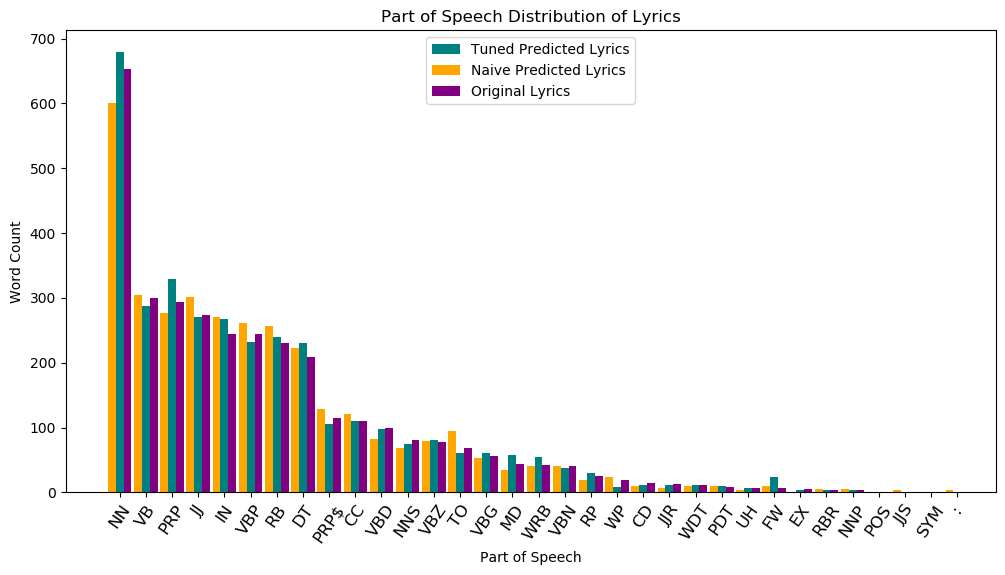

In [90]:
ind = np.arange(len(pos_dist)) # the x locations for the groups
width = .3
plt.figure(figsize=[12,6])
plt.bar(ind+.5*width, pos_dist.tuned_prediction, .3, label='Tuned Predicted Lyrics', color='teal')
plt.bar(ind-.5*width, pos_dist.naive_prediction, .3, label='Naive Predicted Lyrics', color='orange')
plt.bar(ind+1.5*width, pos_dist.actual, .3, label='Original Lyrics', color='purple')
plt.xticks(rotation=55)
plt.legend()
plt.title("Part of Speech Distribution of Lyrics")
plt.xlabel('Part of Speech')
plt.ylabel('Word Count')
plt.xticks(ind + width/2 , (pos_dist.index),rotation=55)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.show()

## Count Frequency

In [96]:
nltk_stop_words = list(stopwords.words('english'))
stop_words = list(get_stop_words('en'))
stop_words.extend(nltk_stop_words)

all_actual_str_no_stop = [w for w in tokenize(all_actual_str) if not w in stop_words]
all_naive_preds_str_no_stop = [w for w in tokenize(all_naive_preds_str) if not w in stop_words]
all_tuned_preds_str_no_stop = [w for w in tokenize(all_tuned_preds_str) if not w in stop_words]


In [97]:
tokenize(all_actual_str)[:10]

['let', 'me', 'down', "don't", 'let', 'me', 'down', "don't", 'let', 'me']

In [98]:
all_actual_str_no_stop[:10]

['let', 'let', 'let', 'love', 'first', 'time', 'know', 'gonna', 'last', 'love']

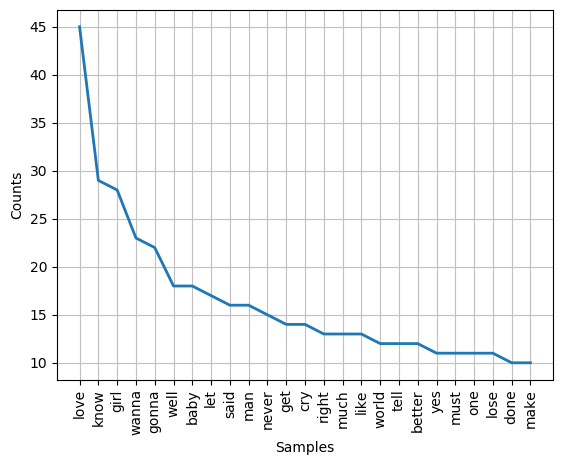

In [32]:
data_analysis = nltk.FreqDist(all_actual_str_no_stop)
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(25, cumulative=False);
plt.title('Frequent Words in Original Lyrics');


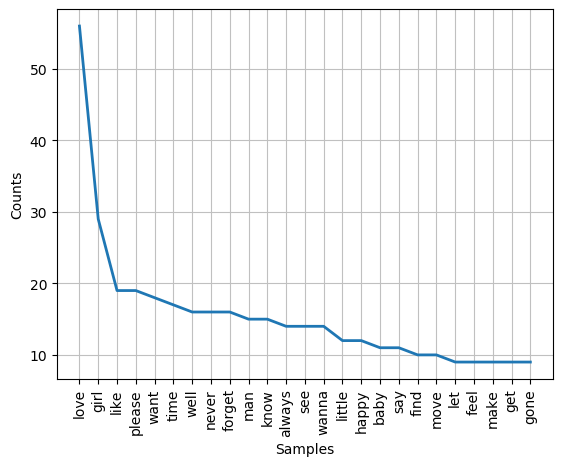

In [99]:
data_analysis = nltk.FreqDist(all_naive_preds_str_no_stop)
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(25, cumulative=False);
plt.title('Frequent Words in Generated Lyrics (Naive)');

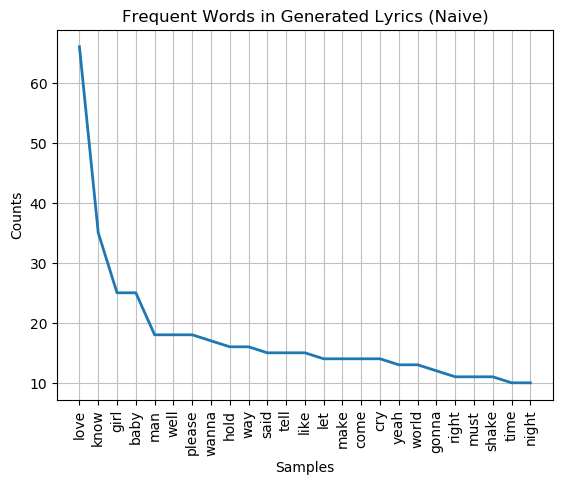

In [100]:
data_analysis = nltk.FreqDist(all_tuned_preds_str_no_stop)
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(25, cumulative=False);
plt.title('Frequent Words in Generated Lyrics (Tuned)');

## Free Text Generation

In [101]:
def generate_text(sequence, max_length, temp):
    model_path = "results_report"
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95, temperature=temp
    )
    return(tokenizer.decode(final_outputs[0], skip_special_tokens=True))

In [105]:
output = naive_model("I am going", max_length=100, num_return_sequences=1, temperature=2.0)[0]['generated_text']
print(output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am going home!" He yelled. They chased their man across the block at whichpoint the pair chased after someone they'd already seen run through the building near 10th and N Streets West.

Once all the men at 11 W Grand didn't return (Derek Johnson, the manager of 646 Park Avenue that housed the crime victims at 11 W Grand told police to check, then that afternoon he checked his telephone phone for an estimated $12,080 the men, not all in masks


In [111]:
output = generate_text("I am going", 100, temp=.3)
print(output)

I am going to get you, I am going to get you in the end Yes I am going to get you in the end Oh yeah, oh yeah I think about you night and day I need you and it's true When I think about you, I can say I'm never, never, never, never blue So I'm telling you, my friend That I'll get you, I'm going to get you in the end Yes I am going to get you in the end Oh yeah,


In [112]:
output = generate_text("I am going", 100, temp=1.0)
print(output)

I am going to find her, oh I know where she's been" That's alright, that's alright, that's alright my Mama said so Yeah she was telling the truth a long, long time ago Now my Mama says she knows where my daddy's been Yeah my Mama says she knows where my daddy's been She says she saw me walk in my door I said, "Mama you're the one" She said, "Yeah I know where your baby's been" Oh yeah Oh


In [108]:
output = generate_text("I am going", 100, temp=2.0)
print(output)

I am going to get you'). Cos I know you'll never be satisfied with me, so I'm going to get you. (Dear Prudence, won't you come out to play? Dear Prudence, greet the brand new day. It's just past twelve and I have less than two hours to go. Will you come out to play? I need a four card monte.) You say you want a revolution Well you know We all want to change the world But till somebody comes along


In [109]:
output = generate_text("I am going", 100, temp=3.0)
print(output)

I am going to leave Memphis, Tennessee Because..." Oh now I've found my calling here in Amarillo, Texas Here I can morn in blue all night long I can hear the games in the park Before the bus arrives Everybody says the jukebox will never drop They're damn near bullshitting Yeah! Singingbirds singing songs in a canteen Speaking Tamil in between texters Eating bacon alone in the hope it brings happiness Please, just come on me I don't care if there's
